### Data fields

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., -October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

In [10]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, normalize 

import numpy as np                   # Multi-dimensional array object
import pandas as pd                  # Data Manipulation
import matplotlib.pyplot as plt      # Data Visualization
import plotly.express as px          # Interactive Data Visualization

from xgboost import plot_importance
from xgboost import XGBRegressor
import pickle

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot # Offline version of the Plotly modules.

from itertools import product



## 1. Feature Pre-processing

1. Use One-Hot-Vector for categorical features

In [11]:
DATA_FOLDER = '../input/'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
submission      = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))

In [12]:
items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [13]:
print(items.item_category_id.unique())
print("Number of Unique ID : ", len(items.item_category_id.unique()))

[40 76 55 19 30 23 37 41 57 43 78 54 49 44 45 77 73 31 75 58 56 38 67 59
 60 74 21 28 20 24 29 70 22 32 62 25 72  4 63 27 18 26 64 15 68  0  2  5
  1  3  6 35 65 14 13 10 11 12 48 71 69  7 33 34 16 66 39 52 46 42 61  8
 80  9 17 36 47 82 81 50 51 79 53 83]
Number of Unique ID :  84


In [14]:
fig = px.histogram(items, x = "item_category_id",
                  labels = {"item_category_id":"Category_id"},
                  title = "Item_Category_Id",
                  )
                  
fig.show()

In [15]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [16]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [17]:
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [18]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [19]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [20]:
print('Number of duplicates:', len(transactions[transactions.duplicated()]))

Number of duplicates: 6


In [21]:
# create all date from 2013.01.01 to 2015.10.31
full_period = []

# create period from 2013.01.01 to 2014.01.31
for year in range(2013, 2015):
    for month in range(1, 13):
        for day in range(1, 32):
            full_period.append(str(day)+"."+str(month)+"."+str(year))

# create period from 2015.01.01 to 2015.10.31
for year in range(2015, 2016):
    for month in range(1, 11):
        for day in range(1, 32):
            full_period.append(str(day)+"."+str(month)+"."+str(year))
            
day_list = ["31.2.2013", "30.2.2013", "29.2.2013", "31.4.2013", "31.6.2013", "31.9.2013", "31.11.2013",
            "31.2.2014", "30.2.2014", "29.2.2014", "31.4.2014", "31.6.2014", "31.9.2014", "31.11.2014",
            "31.2.2015", "30.2.2015", "29.2.2015", "31.4.2015", "31.6.2015", "31.9.2015",]

for w in day_list:
    full_period.remove(w)

## Add feature Russian_public_holiday

In [22]:
Russian_public_holiday = pd.DataFrame()

Full_TimeFrame = pd.DataFrame()

public_holiday = []
for year in ['2013', '2014', '2015']:
    # New Year holidays
    for day in range(1, 11):
        public_holiday.append(str(day) + '.' + '1.' + year)
    # Defender of the Fatherland day
    for day in range(21, 24):
        public_holiday.append(str(day) + '.' + '2.' + year)
    # International Women's Day
    for day in range(6, 12):
        public_holiday.append(str(day) + '.' + '5.' + year)
    # Russia Day
    public_holiday.append('12.6.' + year)
    # National Unity Day
    public_holiday.append('4.11.' + year)

Full_TimeFrame['date'] = full_period

Russian_public_holiday['date'] = public_holiday

Russian_public_holiday['public_holiday'] = 1

Full_df = pd.merge(Full_TimeFrame, Russian_public_holiday, on=['date'], how='outer')


In [23]:
# Fill up non public_holiday to 0.0
Full_df = Full_df.fillna(0.0)

Full_df['year'] = pd.DatetimeIndex(Full_df['date']).year
Full_df['month'] = pd.DatetimeIndex(Full_df['date']).month
Full_df['day'] = pd.DatetimeIndex(Full_df['date']).day

Full_df.drop(['date'], axis=1, inplace=True)

Full_df.head()

,public_holiday,year,month,day
0,1.0,2013,1,1
1,1.0,2013,2,1
2,1.0,2013,3,1
3,1.0,2013,4,1
4,1.0,2013,5,1


In [24]:
transactions['year'] = pd.DatetimeIndex(transactions['date']).year
transactions['month'] = pd.DatetimeIndex(transactions['date']).month
transactions['day'] = pd.DatetimeIndex(transactions['date']).day

In [25]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day
0,02.01.2013,0,59,22154,999.00,1.0,2013,2,1
1,03.01.2013,0,25,2552,899.00,1.0,2013,3,1
2,05.01.2013,0,25,2552,899.00,-1.0,2013,5,1
3,06.01.2013,0,25,2554,1709.05,1.0,2013,6,1
4,15.01.2013,0,25,2555,1099.00,1.0,2013,1,15


In [26]:
# Merge transactions with Full_df dataframe
transactions_with_public_holiday = pd.merge(transactions, Full_df, on=['year', 'month', 'day'],how='inner')

In [27]:
transactions_with_public_holiday.drop(['date'], axis=1, inplace=True)

In [28]:
transactions_with_public_holiday.isnull().sum()

date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
year              0
month             0
day               0
public_holiday    0
dtype: int64

## Revenue of Each Transaction

In [29]:
transactions_with_public_holiday['revenue'] = transactions_with_public_holiday['item_price'] * transactions_with_public_holiday['item_cnt_day']

In [30]:
transactions_with_public_holiday.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,public_holiday,revenue
0,0,59,22154,999.0,1.0,2013,2,1,1.0,999.0
1,0,25,2565,549.0,1.0,2013,2,1,1.0,549.0
2,0,25,2546,299.0,1.0,2013,2,1,1.0,299.0
3,0,25,2715,899.0,1.0,2013,2,1,1.0,899.0
4,0,25,2716,149.0,1.0,2013,2,1,1.0,149.0


## Average Item Price during the Period

In [31]:
Average_item_price = transactions_with_public_holiday.groupby(['shop_id','item_id'])['item_price'].mean().reset_index()

Average_item_price = Average_item_price.rename(columns={'item_price':'average_item_price'}, inplace=False)

In [32]:
transactions_with_average_item_price = pd.merge(transactions_with_public_holiday, Average_item_price,
                                                on=['shop_id','item_id'],
                                                how='inner'
                                               )

## Item Price compare to Average Item Price

In [33]:
transactions_with_average_item_price['item_price_changed'] = transactions_with_average_item_price['item_price'] - transactions_with_average_item_price['average_item_price']

In [34]:
transactions_with_average_item_price.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,public_holiday,revenue,average_item_price,item_price_changed
0,0,59,22154,999.0,1.0,2013,2,1,1.0,999.0,999.0,0.0
1,0,25,2565,549.0,1.0,2013,2,1,1.0,549.0,549.0,0.0
2,0,25,2546,299.0,1.0,2013,2,1,1.0,299.0,299.0,0.0
3,1,25,2546,299.0,1.0,2013,2,2,0.0,299.0,299.0,0.0
4,1,25,2546,299.0,1.0,2013,2,23,1.0,299.0,299.0,0.0


## Create Table to Sum Up Sale for each item by month

In [35]:
sales_by_item_shop_id = transactions.pivot_table(index=['item_id','shop_id'],  # x-axis: item_id
                                            values=['item_cnt_day'],      # y-axis: month
                                            columns='date_block_num',     # x & y Intersection: Sale
                                            aggfunc=np.sum,               # Sum
                                            fill_value=0
                                           ).reset_index()

sales_by_item_shop_id.columns = sales_by_item_shop_id.columns.droplevel().map(str)

sales_by_item_shop_id = sales_by_item_shop_id.reset_index(drop=True).rename_axis(None, axis=1)

sales_by_item_shop_id.columns.values[0] = 'item_id'

sales_by_item_shop_id.columns.values[1] = 'shop_id'

sales_by_item_shop_id.head()

,item_id,shop_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,55,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Downcasting 

In [36]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

transactions = downcast_dtypes(transactions)

transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int16  
 2   shop_id         int16  
 3   item_id         int16  
 4   item_price      float32
 5   item_cnt_day    float32
 6   year            int16  
 7   month           int16  
 8   day             int16  
dtypes: float32(2), int16(6), object(1)
memory usage: 78.4+ MB


<AxesSubplot:>

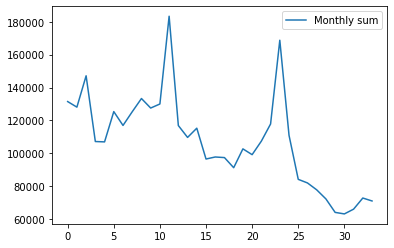

In [37]:
sales_by_item_shop_id.sum()[2:].plot(legend=True, label="Monthly sum")

<AxesSubplot:>

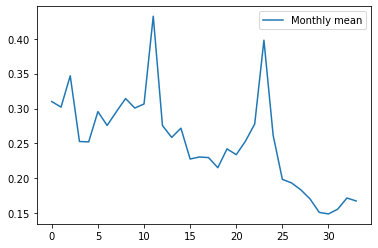

In [38]:
sales_by_item_shop_id.mean()[2:].plot(legend=True, label="Monthly mean")

## Let's see how many products and shops are outdated (no sales for the last 6 months)

In [39]:
# Number of outdated item in training set
outdated_items_and_shop = sales_by_item_shop_id[sales_by_item_shop_id.loc[:,'27':].sum(axis=1)==0]
print('Number of Zero Shop & Sale Item since month 27 :', len(outdated_items_and_shop))

Number of Zero Shop & Sale Item since month 27 : 316974


In [40]:
outdated_items_and_shop['id_shop_item'] = outdated_items_and_shop['shop_id'].astype(str).add('_').add(outdated_items_and_shop['item_id'].astype(str))
outdated_items_and_shop.head()

/tmp/ipykernel_28613/1961744372.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,item_id,shop_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,id_shop_item
0,0,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,54_0
1,1,55,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,55_1
2,2,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,54_2
3,3,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,54_3
4,4,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,54_4


In [41]:
# Number of outdated item and shop in test set (no sales for the last 6 months)
test['id_shop_item'] = test['shop_id'].astype(str).add('_').add(test['item_id'].astype(str))
print('Number of outdate item in test set :', len(test[test['id_shop_item'].isin(outdated_items_and_shop['id_shop_item'])]))

Number of outdate item in test set : 33063


## Outliers by price and sales volume

In [42]:
# Cut off the outliers
transactions = transactions[transactions.item_price < 60000]
transactions = transactions[transactions.item_cnt_day < 680]

In [43]:
## -1 means a product that has  been returned. We are replacing it for now with the median
transactions[transactions['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day
484683,15.05.2013,4,32,2973,-1.0,1.0,2013,5,15


In [44]:
median = transactions[(transactions.shop_id == 32) & (transactions.item_id == 2973) & (transactions.date_block_num == 4)].item_price.median()
transactions.loc[transactions.item_price < 0, 'item_price'] = median

## Shop Closed - No Sales for last 6 months

In [45]:
sales_by_shop_id = transactions.pivot_table(index=['shop_id'],
                                            values=['item_cnt_day'], 
                                            columns='date_block_num', 
                                            aggfunc=np.sum, 
                                            fill_value=0
                                           ).reset_index()

sales_by_shop_id.columns = sales_by_shop_id.columns.droplevel().map(str)
sales_by_shop_id = sales_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop_id.columns.values[0] = 'shop_id'

for i in range(6,34):
    print('Not exists in month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,'0':str(i)].sum(axis=1) == 0].unique())

for i in range(6,28):
    print('Shop is outdated for month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,str(i):].sum(axis=1) == 0].unique())

Not exists in month 6 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 7 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 8 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 9 [11 20 33 34 36 39 40 48 49]
Not exists in month 10 [11 20 33 34 36 39 40 48 49]
Not exists in month 11 [11 20 33 34 36 39 40 48]
Not exists in month 12 [11 20 33 34 36 39 40 48]
Not exists in month 13 [11 20 33 34 36 39 40 48]
Not exists in month 14 [11 20 33 34 36 48]
Not exists in month 15 [11 20 33 34 36]
Not exists in month 16 [11 20 33 34 36]
Not exists in month 17 [11 20 33 34 36]
Not exists in month 18 [11 20 33 36]
Not exists in month 19 [11 20 36]
Not exists in month 20 [11 20 36]
Not exists in month 21 [11 36]
Not exists in month 22 [11 36]
Not exists in month 23 [11 36]
Not exists in month 24 [11 36]
Not exists in month 25 [36]
Not exists in month 26 [36]
Not exists in month 27 [36]
Not exists in month 28 [36]
Not exists in month 29 [36]
Not exists in month 30 [36]
Not exists in month 31 [36]


## Analysis Test Set 

In [46]:
good_sales = test.merge(transactions, on=['item_id','shop_id'], how='left').dropna()
good_pairs = test[test['ID'].isin(good_sales['ID'])]
no_data_items = test[~(test['item_id'].isin(transactions['item_id']))]

print('1. Number of good pairs:', len(good_pairs))
print('2. No Data Items:', len(no_data_items))
print('3. Only Item_id Info:', len(test)-len(no_data_items)-len(good_pairs))

1. Number of good pairs: 111404
2. No Data Items: 15246
3. Only Item_id Info: 87550


## Create Full (Train, Validation, and Test) Set

In [47]:
Full_set = []
cols = ['date_block_num','shop_id','item_id']

# Create product of 3 columns into Full_set 
for i in range(34):
    month_num = transactions_with_average_item_price[transactions_with_average_item_price.date_block_num == i]   
    Full_set.append(np.array(list(product([i], month_num.shop_id.unique(), month_num.item_id.unique())), dtype='int16'))

    
    
# Convert array into dataframe   
Full_set = pd.DataFrame(np.vstack(Full_set), columns=cols)
Full_set['date_block_num'] = Full_set['date_block_num'].astype(np.int8)
Full_set['shop_id'] = Full_set['shop_id'].astype(np.int8)
Full_set['item_id'] = Full_set['item_id'].astype(np.int16)
Full_set.sort_values(cols,inplace=True)



In [48]:
Full_set.head()

,date_block_num,shop_id,item_id
340001,0,0,19
333256,0,0,27
334571,0,0,28
337680,0,0,29
332900,0,0,32


In [49]:
transactions_with_average_item_price.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,public_holiday,revenue,average_item_price,item_price_changed
0,0,59,22154,999.0,1.0,2013,2,1,1.0,999.0,999.0,0.0
1,0,25,2565,549.0,1.0,2013,2,1,1.0,549.0,549.0,0.0
2,0,25,2546,299.0,1.0,2013,2,1,1.0,299.0,299.0,0.0
3,1,25,2546,299.0,1.0,2013,2,2,0.0,299.0,299.0,0.0
4,1,25,2546,299.0,1.0,2013,2,23,1.0,299.0,299.0,0.0


In [50]:
# Sum up daily item sold ('item_cnt_day') and merge into Full_set dataframe
group = transactions_with_average_item_price.groupby(['date_block_num',
                                                'shop_id',
                                                'item_id'
                                               ])['item_cnt_day'].sum().reset_index()

In [51]:
group = group.rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=False)
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [52]:
Full_set = pd.merge(Full_set, group, on=cols, how='left')

Full_set['item_cnt_month'] = (Full_set['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)              # Set 'item_cnt_month' value minimum = 0, max = 20  
                                .astype(np.float16))     ## in the test set has also been clipped and therefore it is advisable

## set floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. 
## If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs. 


In [53]:
test = test.drop("id_shop_item", axis=1)

In [54]:
# Merge test into Full_set
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
Full_set = pd.concat([Full_set, test], ignore_index=True, sort=False, keys=cols)
Full_set.fillna(0, inplace=True) # 34th month (prediction month)

In [55]:
Full_set.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID
0,0,0,19,0.0,0.0
1,0,0,27,0.0,0.0
2,0,0,28,0.0,0.0
3,0,0,29,0.0,0.0
4,0,0,32,6.0,0.0


## Target Lags
- Lag is a time series concept where we hope try to get patters of sales from the previous months. 

- That is more of like saying does the total items sold in a given month have a pattern to the previous month or 2 months before or a year before.

- Now the question how do we know many months of lag should we take into consideration. This more of a trial and error thing. In SARIMA models we could plot ACF and PACF plots and consider how many months of lag that we need to take. Taking 12 months lag is saying what was the patten the same time the previous year.

- On how to choose lags is more of a trial and error and usually people consider a [1,2,3,6,12] lags period but this is just a wild guess and it is upto the individual to expeirment. 

Note: 
- Here we are joining the Full_set dataframe and shifted dataframe by columns of date_block_num,shop_id and item_id. 
- This would lead to a question whether a in a given month the shops and items sold wont be the same when compared to the previous month. 
- This is correct and this would lead to a lot Nan's. We would be dealing with this towards the end and turning them to mostly 0

In [56]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [57]:
Full_set_lag = lag_feature(Full_set, [1,2,3,6,12], 'item_cnt_month')

In [58]:
Full_set_lag.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0,19,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,0.0,NaN,NaN,NaN,NaN,NaN


## Apply Mean Encoded Features

1. Average Sales per month
- The value of the previous months average sales as feature to current month

In [59]:
# Apply Mean Encoded into 'date_block_num'
group = Full_set_lag.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)
Full_set_lag = pd.merge(Full_set_lag, group, on=['date_block_num'], how='left')
Full_set_lag['date_avg_item_cnt'] = Full_set_lag['date_avg_item_cnt'].astype(np.float16)

# Use defined lag_feature function above
Full_set_lag = lag_feature(Full_set_lag, [1], 'date_avg_item_cnt')
Full_set_lag.drop(['date_avg_item_cnt'], axis=1, inplace=True)

2. Calculate the average number of items that are sold for a given item_id in a given date block

In [60]:
# Apply Mean Encoded into 'date_block_num' and 'item_id'
group_1 = Full_set_lag.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group_1.columns = ['date_item_avg_item_cnt']
group_1.reset_index(inplace=True)
Full_set_lag = pd.merge(Full_set_lag, group_1, on=['date_block_num', 'item_id'], how='left')
Full_set_lag['date_item_avg_item_cnt'] = Full_set_lag['date_item_avg_item_cnt'].astype(np.float16)

# Use defined lag_feature function above
Full_set_lag = lag_feature(Full_set_lag, [1, 2, 3, 6, 12], 'date_item_avg_item_cnt')
Full_set_lag.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

3. Calculate the average number of items that are sold for a given shop_id in a given date block

In [61]:
# Apply Mean Encoded into 'date_block_num' and 'shop_id'
group_2 = Full_set_lag.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group_2.columns = [ 'date_shop_avg_item_cnt' ]
group_2.reset_index(inplace=True)
Full_set_lag = pd.merge(Full_set_lag, group_2, on=['date_block_num', 'shop_id'], how='left')
Full_set_lag['date_shop_avg_item_cnt'] = Full_set_lag['date_shop_avg_item_cnt'].astype(np.float16)

# Use defined lag_feature function above
Full_set_lag = lag_feature(Full_set_lag, [1,2,3,6,12], 'date_shop_avg_item_cnt')
Full_set_lag.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

## Add number of public holiday for each month as feature

In [62]:
holiday_month = [10, 3, 3, 0, 6, 1, 0, 0, 0, 0, 1, 0,
                 10, 3, 3, 0, 6, 1, 0, 0, 0, 0, 1, 0,
                 10, 3, 3, 0, 6, 1, 0, 0, 0, 0, 1
                 ]
holiday_num_month = []

for d in Full_set_lag['date_block_num']:
    holiday_num_month.append(holiday_month[d])

Full_set_lag['holiday_num_month'] = holiday_num_month

In [63]:
Full_set_lag.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,...,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,holiday_num_month
0,0,0,19,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
1,0,0,27,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
2,0,0,28,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
3,0,0,29,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
4,0,0,32,6.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


4. Calculate the average number of items that are sold for a given public holiday in a given date block

In [64]:
# Apply Mean Encoded into 'date_block_num' and 'shop_id'
group_0 = Full_set_lag.groupby(['date_block_num', 'holiday_num_month']).agg({'item_cnt_month': ['mean']})
group_0.columns = ['date_holiday_avg_item_cnt']
group_0.reset_index(inplace=True)
Full_set_lag = pd.merge(Full_set_lag, group_0, on=['date_block_num', 'holiday_num_month'], how='left')
Full_set_lag['date_holiday_avg_item_cnt'] = Full_set_lag['date_holiday_avg_item_cnt'].astype(np.float16)

# Use defined lag_feature function above
Full_set_lag = lag_feature(Full_set_lag, [1, 2, 3, 6, 12], 'date_holiday_avg_item_cnt')
Full_set_lag.drop(['date_holiday_avg_item_cnt'], axis=1, inplace=True)

In [65]:
Full_set_lag.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,...,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,holiday_num_month,date_holiday_avg_item_cnt_lag_1,date_holiday_avg_item_cnt_lag_2,date_holiday_avg_item_cnt_lag_3,date_holiday_avg_item_cnt_lag_6,date_holiday_avg_item_cnt_lag_12
0,0,0,19,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN


## Trend Feature - Price trend for last six months

In [66]:
# Creating a column to get the average price for each item based on its item_id
group_3 = transactions_with_average_item_price.groupby(['item_id']).agg({'item_price': ['mean']})
group_3.columns = ['item_avg_item_price']
group_3.reset_index(inplace=True)
Full_set_lag = pd.merge(Full_set_lag, group_3, on=['item_id'], how='left')
Full_set_lag['item_avg_item_price'] = Full_set_lag['item_avg_item_price'].astype(np.float16)


# Creating a column to get the average price for each item based on grouping by date_block_num and item_id
group_4 = transactions_with_average_item_price.groupby(['date_block_num', 'item_id']).agg({'item_price': ['mean']})
group_4.columns = ['date_item_avg_item_price']
group_4.reset_index(inplace=True)
Full_set_lag = pd.merge(Full_set_lag, group_4, on=['date_block_num', 'item_id'], how='left')
Full_set_lag['date_item_avg_item_price'] = Full_set_lag['date_item_avg_item_price'].astype(np.float16)

# This is an important step because here columns are created for a lag of 1-6 months based on the combination of date_block
# and item_id. Basically this tell us what was the price last month, last 2 months...upto last 6 months of the given item
# of a given date block.
lags = [1, 2, 3, 4, 5, 6]
Full_set_lag = lag_feature(Full_set_lag, lags, 'date_item_avg_item_price')


## Get the Price Trend

- That is it indicates the ratio of the avg item price (let it be x1) for the last month to the avg item price (x) for the whole set.

- Hence, for the last month trend_feature = (x1 - x)/x. for example, if last month price is greather then avg price, then the final value is more then zero (positive trend).

- if last month price is lesser than avg price, then the value is less than zero (negative trend). 

- Finaly, if last month price is close to avg price then the trend will be close to zero.

**because of the existence of items wich were not sold last month we use lags for date_item_avg_item_price property. Thus, if We cant get last month trend we take a trend for two months (x2-x)/x and so on.probably the name of the feature 'delta_price_lag' should be 'price_trend'.**

In [67]:
for i in lags:
    Full_set_lag['delta_price_lag_'+str(i)] = \
        (Full_set_lag['date_item_avg_item_price_lag_'+str(i)] - Full_set_lag['item_avg_item_price']) / Full_set_lag['item_avg_item_price']

In [68]:
# Create a new column to understand latest trend of a given product
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_' + str(i)]:
            return row['delta_price_lag_' + str(i)]
    return 0


Full_set_lag['delta_price_lag'] = Full_set_lag.apply(select_trend, axis=1)
Full_set_lag['delta_price_lag'] = Full_set_lag['delta_price_lag'].astype(np.float16)
Full_set_lag['delta_price_lag'].fillna(0, inplace=True)

In [ ]:
# Dropping columns such as date_item_avg_price_lag and delta_price_lag
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]
Full_set_lag.drop(fetures_to_drop, axis=1, inplace=True)

In [ ]:
Full_set_lag.head()

## Last month shop revenue trend

- Calculate the revenue trend and then create a lag for only the previous month.
- Unlike the previous case where we created it for the last months (1-6). This is obvious because ceach shops latest trend can be seen in the previous month of revenue as there wont be any shops with having a revenue the previous month unlike items that could have been sold the previous month or the one before or upto 6 months.

In [ ]:
transactions_with_average_item_price.head()

In [ ]:
## Grouping by date_block_num and shop_id and summing the total revenue
group_revenue = transactions_with_average_item_price.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group_revenue.columns = ['date_shop_revenue']
group_revenue.reset_index(inplace=True)

## Creating a column for the revenue date_shop_revenue
Full_set_lag = pd.merge(Full_set_lag, group_revenue, on=['date_block_num','shop_id'], how='left')
Full_set_lag['date_shop_revenue'] = Full_set_lag['date_shop_revenue'].astype(np.float32)

## Here we are grouping the revenue values by finding the mean over the shop id
group_revenue = group_revenue.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group_revenue.columns = ['shop_avg_revenue']
group_revenue.reset_index(inplace=True)

## Adding this to the Full_set_lag
Full_set_lag = pd.merge(Full_set_lag, group_revenue, on=['shop_id'], how='left')
Full_set_lag['shop_avg_revenue'] = Full_set_lag['shop_avg_revenue'].astype(np.float32)

## Doing the same as above that we did for price
Full_set_lag['delta_revenue'] = (Full_set_lag['date_shop_revenue'] - Full_set_lag['shop_avg_revenue']) / Full_set_lag['shop_avg_revenue']
Full_set_lag['delta_revenue'] = Full_set_lag['delta_revenue'].astype(np.float16)

## Adding only lag for the previous month
Full_set_lag = lag_feature(Full_set_lag, [1], 'delta_revenue')
Full_set_lag.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

## Addition Feature - Number of Days for each month

In [ ]:
Full_set_lag['month'] = Full_set_lag['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
Full_set_lag['days'] = Full_set_lag['month'].map(days).astype(np.int8)

## Months since the first sale for each shop/item pair and for item only.

In [ ]:
Full_set_lag['item_shop_first_sale'] = Full_set_lag['date_block_num'] - Full_set_lag.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
Full_set_lag['item_first_sale'] = Full_set_lag['date_block_num'] - Full_set_lag.groupby('item_id')['date_block_num'].transform('min')

## Removing all rows from that are in the date_block_num for the first 11 months

Full_set_lag = Full_set_lag[matrix.date_block_num > 11]

In [ ]:
Full_set_lag.head()

In [ ]:
# Fill nulls with zeros

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

Full_set_lag = fill_na(Full_set_lag)

In [ ]:
Full_set_lag.to_pickle('Full_set_lag.pkl')

## XGBoost

In [ ]:
import pandas as pd
import xgboost as xgb

In [ ]:
data = pd.read_pickle('Full_set_lag.pkl')

In [ ]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']

X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']

X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42,
    tree_method='gpu_hist')

In [ ]:
model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:1.10690	validation_1-rmse:1.05693
[1]	validation_0-rmse:1.03225	validation_1-rmse:1.00168
[2]	validation_0-rmse:0.99264	validation_1-rmse:0.97500
[3]	validation_0-rmse:0.96823	validation_1-rmse:0.96019
[4]	validation_0-rmse:0.95423	validation_1-rmse:0.95274
[5]	validation_0-rmse:0.94617	validation_1-rmse:0.94962
[6]	validation_0-rmse:0.94027	validation_1-rmse:0.94847
[7]	validation_0-rmse:0.93591	validation_1-rmse:0.94689
[8]	validation_0-rmse:0.93258	validation_1-rmse:0.94568
[9]	validation_0-rmse:0.93105	validation_1-rmse:0.94606
[10]	validation_0-rmse:0.92888	validation_1-rmse:0.94662
[11]	validation_0-rmse:0.92749	validation_1-rmse:0.94598
[12]	validation_0-rmse:0.92573	validation_1-rmse:0.94457
[13]	validation_0-rmse:0.92473	validation_1-rmse:0.94512
[14]	validation_0-rmse:0.92344	validation_1-rmse:0.94604
[15]	validation_0-rmse:0.92202	validation_1-rmse:0.94546
[16]	validation_0-rmse:0.92117	validation_1-rmse:0.94645
[17]	validation_0-rmse:0.92058	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.3, gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=8, min_child_weight=300, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

In [ ]:
## Note: We are clipping values here because the evaluation rules of the competition had said to clip the values
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_211115.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [ ]:
def plot_features(booster, figsize):    
    _, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))